In [5]:
import torch.onnx
import torchvision
import torch
import numpy as np
from torch.autograd import Variable
from model_thermal_rgb import Discriminator, Generator
from config import Config
from thermal_dataset import ThermalImageDataset as ImageDataset
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import scipy.misc
from torchvision.utils import save_image
from tifffile import imsave, imread

In [3]:
config = Config()
model = Generator()
model.load_state_dict(torch.load('results/2022-05-01-ThermalRGB_NCCLoss_Fixbug/g-last.pth'))
#model.load_state_dict(torch.load('samples/2022-05-01-ThermalRGB_NCCLoss_Fixbug/g_epoch_121.pth'))
model.to(config.device)
model.eval()

Generator(
  (conv_block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
  )
  (conv_block1_2): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
  )
  (trunk): Sequential(
    (0): ResidualConvBlock(
      (rcb): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualConvBlock(
      (rcb): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

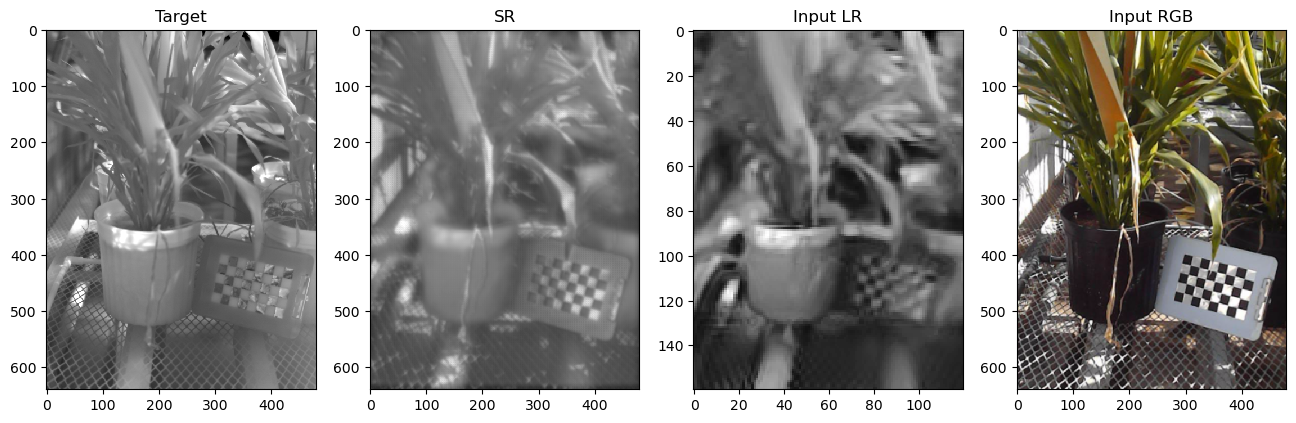

In [21]:
# Test Image
#sample_dataset = ImageDataset(dataroot="/home/lion397/data/datasets/GEMINI/Training_220315/val/",image_size=96, upscale_factor=4, mode="train")
sample_dataset = ImageDataset(dataroot="/home/lion397/data/datasets/GEMINI/Training_220315/val",image_size=96, upscale_factor=4, mode="train")
(low_img, rgb_img, high_ir) = sample_dataset.getImage(10)
rgb_img_disp = rgb_img
low_img = torch.FloatTensor(low_img)[None, None,:, :]/255.0
rgb_img = rgb_img[:, :, [2, 1, 0]] # swap channel from RGB to BGR
rgb_img = torch.FloatTensor(rgb_img).permute(2,0,1).unsqueeze(0)/255.0
high_ir = torch.FloatTensor(high_ir)[None, None,:, :]/255.0
lr = low_img.to(config.device, non_blocking=True)
rgb = rgb_img.to(config.device, non_blocking=True)
high_ir = high_ir.to(config.device, non_blocking=True)
sr = model(lr, rgb)
sr_img = sr.squeeze().cpu().detach().numpy()
lr_img = lr.squeeze().cpu().detach().numpy()
high_img = high_ir.squeeze().cpu().detach().numpy()
# plt.imshow(sr_img,cmap='gray')
f, axarr = plt.subplots(1,4, figsize=(16,8))
im0 = axarr[0].imshow(high_img, interpolation='none', cmap='gray')
axarr[0].set_title("Target")
#plt.colorbar(im0, ax=axarr[0])
im1 = axarr[1].imshow(sr_img, interpolation='none', cmap='gray',vmin=0, vmax=1.0)
axarr[1].set_title("SR")
#plt.colorbar(im1, ax=axarr[1])
im2 = axarr[2].imshow(lr_img, interpolation='none', cmap='gray',vmin=0, vmax=1.0)
axarr[2].set_title("Input LR")
#plt.colorbar(im2, ax=axarr[2])
im3 = axarr[3].imshow(cv2.cvtColor(rgb_img_disp,cv2.COLOR_RGB2BGR),interpolation='none')
axarr[3].set_title("Input RGB")
#plt.colorbar(im3, ax=axarr[3])

plt.show()

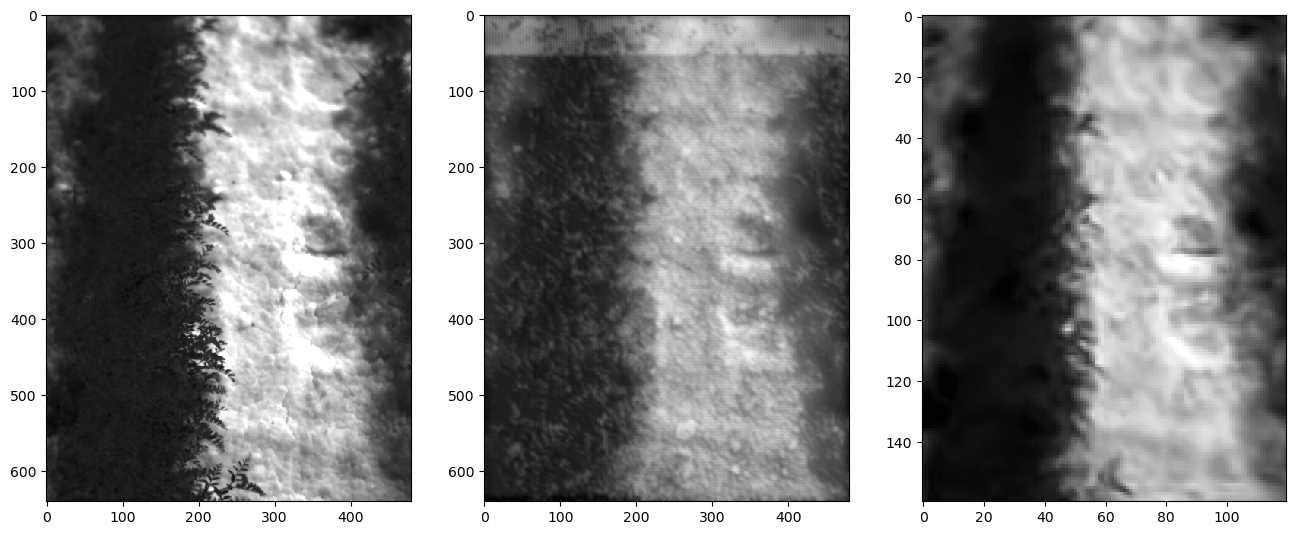

In [5]:
# Test Image
sample_dataset = ImageDataset(dataroot="/home/lion397/data/datasets/GEMINI/2022-04-05-Garbanzo/pairs_processed",
                                image_size=96, upscale_factor=4, mode="train")
(low_img, rgb_img, high_ir) = sample_dataset.getImage(20)
low_img = torch.FloatTensor(low_img)[None, None,:, :]/255.0
rgb_img = rgb_img[:, :, [2, 1, 0]] # swap channel from RGB to BGR
rgb_img = torch.FloatTensor(rgb_img).permute(2,0,1).unsqueeze(0)/255.0

high_ir = torch.FloatTensor(high_ir)[None, None,:, :]/255.0

lr = low_img.to(config.device, non_blocking=True)
rgb = rgb_img.to(config.device, non_blocking=True)
high_ir = high_ir.to(config.device, non_blocking=True)

sr = model(lr, rgb)

sr_img = sr.squeeze().cpu().detach().numpy()
lr_img = lr.squeeze().cpu().detach().numpy()
high_img = high_ir.squeeze().cpu().detach().numpy()
# plt.imshow(sr_img,cmap='gray')

f, axarr = plt.subplots(1,3, figsize=(16,8))
axarr[0].imshow(high_img, interpolation='none', cmap='gray')
axarr[1].imshow(sr_img, interpolation='none', cmap='gray')
axarr[2].imshow(lr_img, interpolation='none', cmap='gray')

In [12]:
def create_dir(dir_):
    os.makedirs(dir_, exist_ok = True)
    
def process_dataset(dataroot, prefix, debug = False, write_img = True):
    # dataroot = "../../../datasets/GEMINI/2022-02-22-Greenhouse/"

    sr_dataroot_save = os.path.join(dataroot,"IR_ThermalRGB")
    create_dir(sr_dataroot_save)

    sample_dataset = ImageDataset(dataroot=dataroot,
                                image_size=96, upscale_factor=4, mode="train")

    for i in tqdm(range(len(sample_dataset.low_filenames))):
        (low_img, rgb_img, high_ir) = sample_dataset.getImage(i)

        low_img = torch.FloatTensor(low_img)[None, None,:, :]/255.0
        rgb_img = rgb_img[:, :, [2, 1, 0]] # swap channel from RGB to BGR
        rgb_img = torch.FloatTensor(rgb_img).permute(2,0,1).unsqueeze(0)/255.0

        high_ir = torch.FloatTensor(high_ir)[None, None,:, :]/255.0

        lr = low_img.to(config.device, non_blocking=True)
        rgb = rgb_img.to(config.device, non_blocking=True)
        high_ir = high_ir.to(config.device, non_blocking=True)

        sr = model(lr, rgb)

        sr_img = sr.squeeze().cpu().detach().numpy()
        lr_img = lr.squeeze().cpu().detach().numpy()
        high_img = high_ir.squeeze().cpu().detach().numpy()

        sr_name = '{prefix}_SR_480x640_{i:05d}.png'.format(prefix=prefix, i=i)

        if write_img:
            if 1:
                sr_img *= 255 # or any coefficient
                sr_img = sr_img.astype(np.uint8)
                cv2.imwrite(os.path.join(sr_dataroot_save,sr_name), sr_img)
            else:
                save_image(sr,os.path.join(sr_img,sr_name))

process_dataset(dataroot="/home/lion397/data/datasets/GEMINI/2022-04-05-Garbanzo/pairs_processed",prefix="220531_ThermalRGB",debug=False, write_img=True)

100%|██████████| 170/170 [00:08<00:00, 20.84it/s]


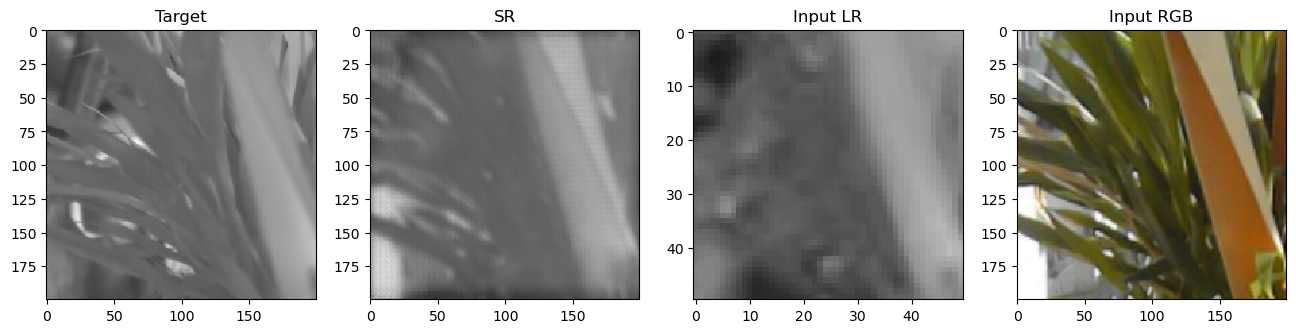

In [4]:
# Test Image
#sample_dataset = ImageDataset(dataroot="/home/lion397/data/datasets/GEMINI/Training_220315/val/",image_size=96, upscale_factor=4, mode="train")
sample_dataset = ImageDataset(dataroot="/home/lion397/data/datasets/GEMINI/Training_220315/val",image_size=96, upscale_factor=4, mode="train")
(low_img, rgb_img, high_ir) = sample_dataset.getImage(10)
crop_bbox = [0,0,200,200]
low_img = low_img[crop_bbox[0]//4:crop_bbox[2]//4,crop_bbox[1]//4:crop_bbox[3]//4]
rgb_img = rgb_img[crop_bbox[0]:crop_bbox[2],crop_bbox[1]:crop_bbox[3]]
high_ir = high_ir[crop_bbox[0]:crop_bbox[2],crop_bbox[1]:crop_bbox[3]]

rgb_img_disp = rgb_img
low_img = torch.FloatTensor(low_img)[None, None,:, :]/255.0
rgb_img = rgb_img[:, :, [2, 1, 0]] # swap channel from RGB to BGR
rgb_img = torch.FloatTensor(rgb_img).permute(2,0,1).unsqueeze(0)/255.0
high_ir = torch.FloatTensor(high_ir)[None, None,:, :]/255.0
lr = low_img.to(config.device, non_blocking=True)
rgb = rgb_img.to(config.device, non_blocking=True)
high_ir = high_ir.to(config.device, non_blocking=True)
sr = model(lr, rgb)
sr_img = sr.squeeze().cpu().detach().numpy()
lr_img = lr.squeeze().cpu().detach().numpy()
high_img = high_ir.squeeze().cpu().detach().numpy()
# plt.imshow(sr_img,cmap='gray')
f, axarr = plt.subplots(1,4, figsize=(16,8))
im0 = axarr[0].imshow(high_img, interpolation='none', cmap='gray',vmin=0, vmax=1.0)
axarr[0].set_title("Target")
#plt.colorbar(im0, ax=axarr[0])
im1 = axarr[1].imshow(sr_img, interpolation='none', cmap='gray',vmin=0, vmax=1.0)
#im1 = axarr[1].imshow(sr_img, interpolation='none', cmap='gray')
axarr[1].set_title("SR")
#plt.colorbar(im1, ax=axarr[1])
im2 = axarr[2].imshow(lr_img, interpolation='none', cmap='gray',vmin=0, vmax=1.0)
#im2 = axarr[2].imshow(lr_img, interpolation='none', cmap='gray')
axarr[2].set_title("Input LR")
#plt.colorbar(im2, ax=axarr[2])
im3 = axarr[3].imshow(cv2.cvtColor(rgb_img_disp,cv2.COLOR_RGB2BGR),interpolation='none')
axarr[3].set_title("Input RGB")
#plt.colorbar(im3, ax=axarr[3])

plt.show()

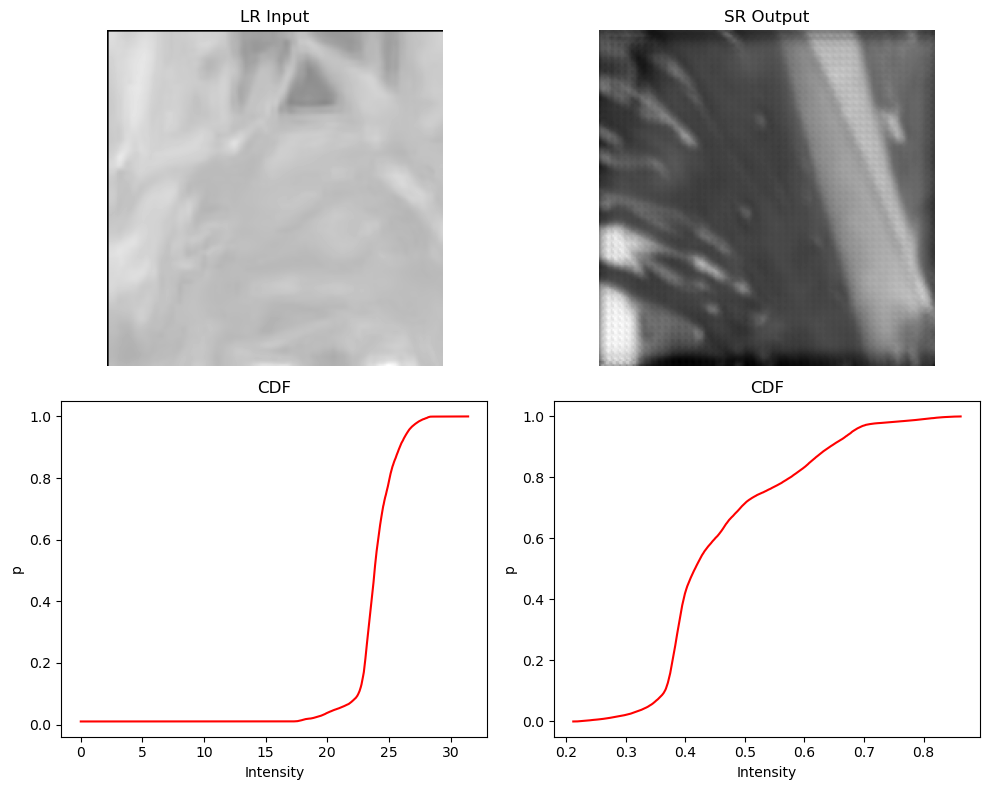

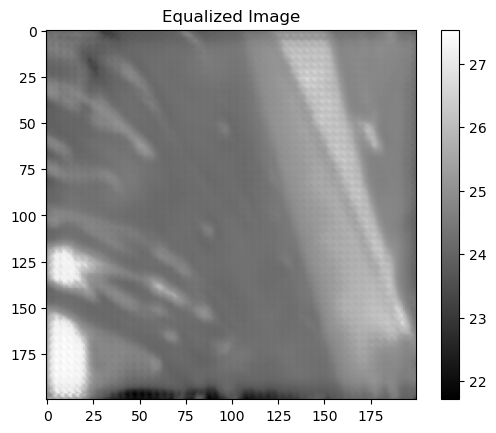

In [32]:
# Load the two input images
image1 = sr_img  # Load as grayscale
if 0:
    image2 = lr_img  # Load as grayscale
else:
    image2 = imread("IMG_0339_IR.tiff") / 1000

    # Specify the rotation angle
    angle = 180  # Rotate by 45 degrees clockwise

    # Calculate the image center
    height, width = image2.shape[:2]
    center = (width / 2, height / 2)

    # Define the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Apply the rotation to the image
    rotated_image = cv2.warpAffine(image2, rotation_matrix, (width, height))

    #image2 = cv2.resize(image2, dsize=(rgb_img.shape[1]//4,rgb_img.shape[0]//4))
    crop_bbox = [0,0,200,200]
    image2 = rotated_image[crop_bbox[0]:crop_bbox[2],crop_bbox[1]:crop_bbox[3]]
    #image2 = rotated_image

# Calculate the histogram of the first image
n_bins = 1000
#hist1, bins1 = np.histogram(image1.flatten(), n_bins,[0,1],density=True)
hist1, bins1 = np.histogram(image1.flatten(), n_bins, density=True)

# Calculate the cumulative distribution function (CDF) of the first image
cdf1 = hist1.cumsum()
cdf1_normalized = cdf1 / cdf1.max()

# Calculate the histogram of the second image
hist2, bins2 = np.histogram(image2.flatten(), n_bins,density=True)

# Calculate the cumulative distribution function (CDF) of the second image
cdf2 = hist2.cumsum()
cdf2_normalized = cdf2  / cdf2.max()

# Perform histogram equalization
cdf_mapping = np.interp(cdf1_normalized, cdf2_normalized, bins2[:-1])
#cdf_mapping = np.interp(cdf1, cdf2, bins2[:-1])
image1_equalized = cdf_mapping[np.round(image1 * n_bins).astype('uint32')]

# Display the original and equalized images
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].imshow(image2, cmap='gray')
ax[0, 0].set_title('LR Input')
ax[0, 0].axis('off')
ax[0, 1].imshow(image1, cmap='gray')
ax[0, 1].set_title('SR Output')
ax[0, 1].axis('off')
#ax[1, 0].hist(image2.flatten(), 256, [0, 1], color='r')
ax[1, 0].plot(bins2[:-1],cdf2_normalized,color='r')
#ax[1, 0].set_title('LR Input')
ax[1, 0].set_title('CDF')
ax[1, 0].set_xlabel("Intensity")
ax[1, 0].set_ylabel("p")
#ax[1, 1].hist(image1.flatten(), 256, [0, 1], color='r')
ax[1, 1].plot(bins1[:-1],cdf1_normalized,color='r')
#ax[1, 1].set_title('SR Output')
ax[1, 1].set_title('CDF')
ax[1, 1].set_xlabel("Intensity")
ax[1, 1].set_ylabel("p")
plt.tight_layout()
plt.show()

# Display the equalized image
plt.imshow(image1_equalized,cmap="gray")
plt.title('Equalized Image')
plt.colorbar()

Text(0.5, 1.0, 'Input LR')

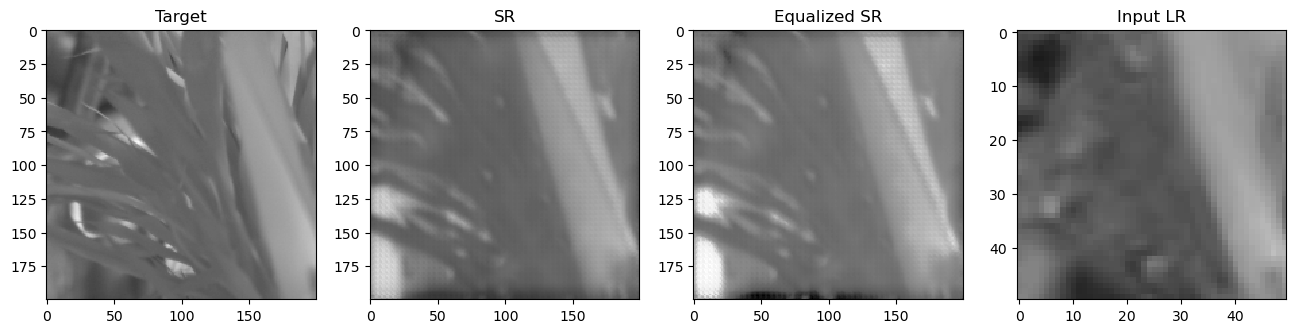

In [34]:
f, axarr = plt.subplots(1,4, figsize=(16,8))
im0 = axarr[0].imshow(high_img, interpolation='none', cmap='gray',vmin=0, vmax=1.0)
axarr[0].set_title("Target")
#plt.colorbar(im0, ax=axarr[0])
im1 = axarr[1].imshow(sr_img, interpolation='none', cmap='gray',vmin=0, vmax=1.0)
axarr[1].set_title("SR")

im2 = axarr[2].imshow(image1_equalized, interpolation='none', cmap='gray',vmin=0, vmax=1.0)
axarr[2].set_title("Equalized SR")
# plt.colorbar(im2, ax=axarr[2])
im2 = axarr[3].imshow(lr_img, interpolation='none', cmap='gray',vmin=0, vmax=1.0)
axarr[3].set_title("Input LR")


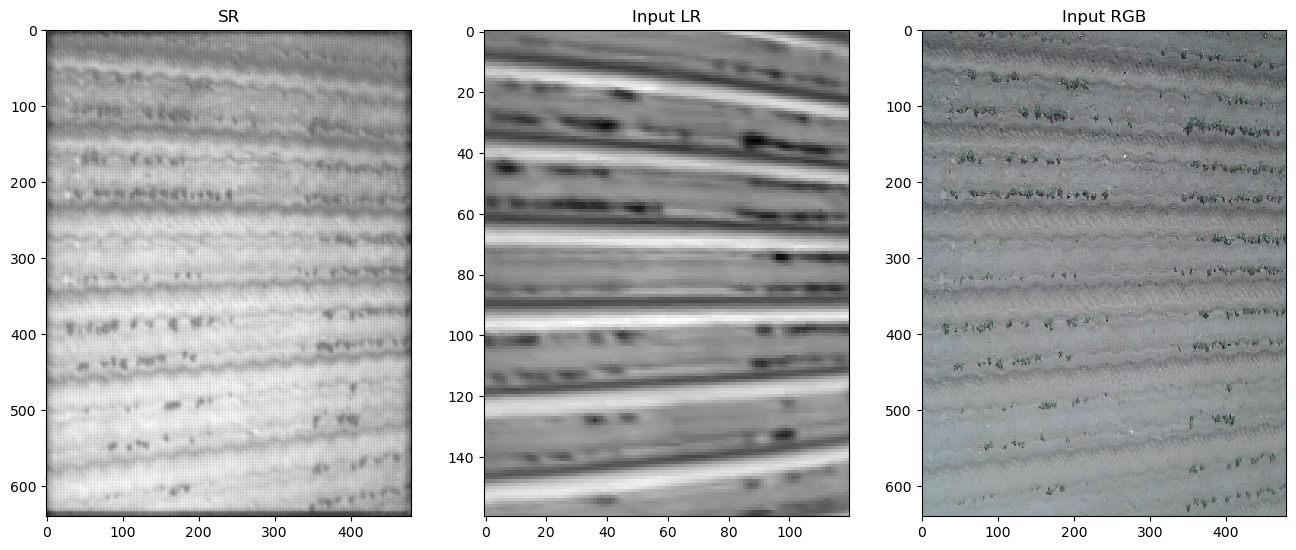

In [6]:
from tifffile import imsave, imread
# Test Image
rgb_img = cv2.imread("/home/GEMINI/Dataset/Davis_Legumes/2022-06-20/Drone/iPhone/backup/flir_processed/220620_IMG_01570_RGB.jpg")
rgb_img = cv2.resize(rgb_img,dsize=(480,640))
low_img = imread("/home/GEMINI/Dataset/Davis_Legumes/2022-06-20/Drone/iPhone/flir_processed/1_IR/220620_IMG_01570_IR.tiff") / 1000
low_img = cv2.resize(low_img, dsize=(rgb_img.shape[1]//4,rgb_img.shape[0]//4))

if 0:
    crop_bbox = [0,0,200,200]
    low_img = low_img[crop_bbox[0]//4:crop_bbox[2]//4,crop_bbox[1]//4:crop_bbox[3]//4]
    rgb_img = rgb_img[crop_bbox[0]:crop_bbox[2],crop_bbox[1]:crop_bbox[3]]
    high_ir = high_ir[crop_bbox[0]:crop_bbox[2],crop_bbox[1]:crop_bbox[3]]

rgb_img_disp = rgb_img
low_img = torch.FloatTensor(low_img)[None, None,:, :]/255.0
rgb_img = rgb_img[:, :, [2, 1, 0]] # swap channel from RGB to BGR
rgb_img = torch.FloatTensor(rgb_img).permute(2,0,1).unsqueeze(0)/255.0
#high_ir = torch.FloatTensor(high_ir)[None, None,:, :]/255.0
lr = low_img.to(config.device, non_blocking=True)
rgb = rgb_img.to(config.device, non_blocking=True)
#high_ir = high_ir.to(config.device, non_blocking=True)
sr = model(lr, rgb)
sr_img = sr.squeeze().cpu().detach().numpy()
lr_img = lr.squeeze().cpu().detach().numpy()

# plt.imshow(sr_img,cmap='gray')
f, axarr = plt.subplots(1,3, figsize=(16,8))
#plt.colorbar(im0, ax=axarr[0])
im1 = axarr[0].imshow(sr_img, interpolation='none', cmap='gray')
#im1 = axarr[1].imshow(sr_img, interpolation='none', cmap='gray')
axarr[0].set_title("SR")
#plt.colorbar(im1, ax=axarr[1])
im2 = axarr[1].imshow(lr_img, interpolation='none', cmap='gray')
#im2 = axarr[2].imshow(lr_img, interpolation='none', cmap='gray')
axarr[1].set_title("Input LR")
#plt.colorbar(im2, ax=axarr[2])
im3 = axarr[2].imshow(cv2.cvtColor(rgb_img_disp,cv2.COLOR_RGB2BGR),interpolation='none')
axarr[2].set_title("Input RGB")
#plt.colorbar(im3, ax=axarr[3])

plt.show()